# Load

In [6]:
import torch
import torch.nn as nn
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152
from torchvision import transforms

from PIL import Image

In [7]:
import matplotlib.pyplot as plt

# Classes

In [8]:
from src.model import SSD300

In [9]:
def load_checkpoint(model, checkpoint):
    """
    Load model from checkpoint.
    """
    print("loading model checkpoint", checkpoint)
    od = torch.load(checkpoint)

    # remove proceeding 'N.' from checkpoint that comes from DDP wrapper
    saved_model = od["model"]
    model.load_state_dict(saved_model)


In [10]:
model = SSD300()
load_checkpoint(model, '/scratch/coco/save_dir_bs64/epoch_80.pt')
model

loading model checkpoint /scratch/coco/save_dir_bs64/epoch_80.pt


SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [11]:
distinct_colors = ['#e6194b', '#3cb44b', '#f59542', '#0082c8']
from torchvision import transforms
from PIL import Image

def show_detections_for_real_image(model, img_path, detection_threshold = 0.5):
    model.eval()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    img = Image.open(img_path)
    tsfm = transforms.ToTensor()
    sample = tsfm(img)
    outputs = model(sample.cuda().unsqueeze(0))
    sample = sample.permute(1,2,0).cpu().numpy()
    labels = outputs[0]['labels'].data.cpu().numpy()
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    labels = labels[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold].astype(np.float16)
    for label, box, score in zip(labels,boxes, scores):
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,linewidth=2,edgecolor=distinct_colors[label-1],facecolor='none', label='l')
        ax.text(xmin, ymin-10, 'Score: ' + str(score))

        ax.add_patch(rect)

    ax.set_axis_off()
    ax.imshow(sample)

## show detection 

In [12]:
model = model.cuda()
model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [13]:
from src.utils import dboxes300_coco, Encoder

import os
import matplotlib.patches as patches

folder = '/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/'
os.listdir(folder)[:5]

['image_527_Standard_staticforeignobjects.png',
 'image_528_Standard_staticforeignobjects.png',
 'image_529_Standard_staticforeignobjects.png',
 'image_530_Standard_staticforeignobjects.png',
 'image_531_Standard_staticforeignobjects.png']

In [21]:
def get_bbox_pred(model, img):
    """ get bounding box predictions for a specific image"""
    dboxes = dboxes300_coco()
    encoder = Encoder(dboxes)

    wtot, htot = img.size

    tsfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((300, 300))
    ])
    inp = tsfm(img).cuda().unsqueeze(0)


    # Handle the batch of predictions produced
    # This is slow, but consistent with old implementation.
    bboxes = []
    with torch.no_grad():
        # Get predictions
        ploc, plabel = model(inp)
        ploc, plabel = ploc.float(), plabel.float()

        for idx in range(ploc.shape[0]):
            # ease-of-use for specific predictions
            ploc_i = ploc[idx, :, :].unsqueeze(0)
            plabel_i = plabel[idx, :, :].unsqueeze(0)

            result = encoder.decode_batch(ploc_i, plabel_i, 0.50, 200)[0]

            loc, label, prob = [r.cpu().numpy() for r in result]
            for loc_, label_, prob_ in zip(loc, label, prob):
                label = 1
                xmin, ymin = loc_[0] * wtot, loc_[1] * htot
                w, h = (loc_[2] - loc_[0]) * wtot, (loc_[3] - loc_[1]) * htot
                score = prob_
                
                bboxes.append((label, xmin, ymin, w, h, score))
    
    return bboxes

In [74]:
def plot_bboxes(bboxes, img):
    labels = ["background", "bolt"]
    fig, ax = plt.subplots(1, 1,)
    
    for idx, (l, xmin, ymin, w, h, score) in enumerate(bboxes):
        rect = patches.Rectangle((xmin, ymin), w, h,linewidth=2,edgecolor=distinct_colors[idx],facecolor='none', label='l')
        ax.text(xmin, ymin-10, f"{labels[l]}: {score:.2f}")

        ax.add_patch(rect)

    ax.set_axis_off()
    ax.imshow(img)
    
    return ax,fig

/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_527_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_528_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_529_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_530_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_531_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_532_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_533_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_534_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_535_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_536_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWA

<ipython-input-74-ed43fb35574e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1,)


/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_959_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_960_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_961_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_962_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_963_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_964_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_965_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_966_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_967_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/image_968_Standard_staticforeignobjects_bbox.png
/scratch/coco/FTI_BOLTS_SIDEWA

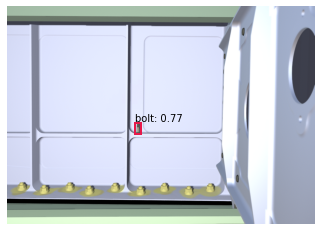

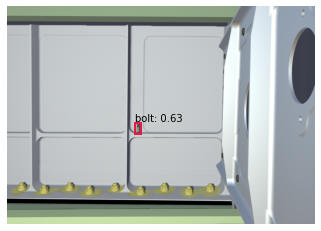

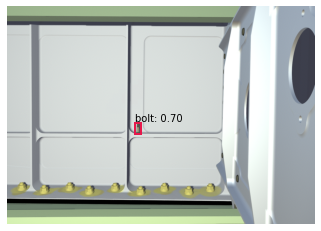

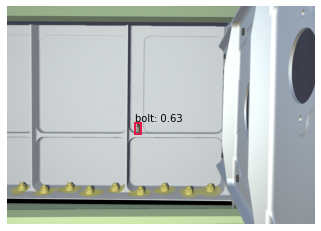

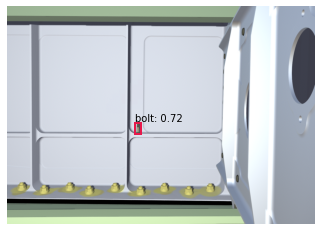

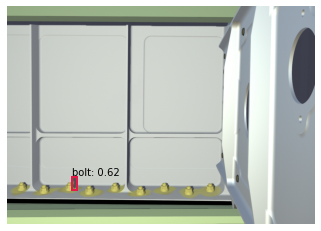

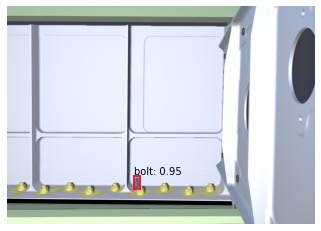

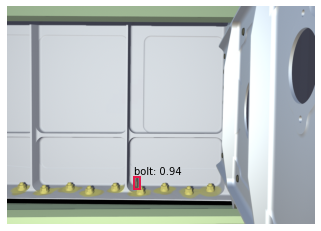

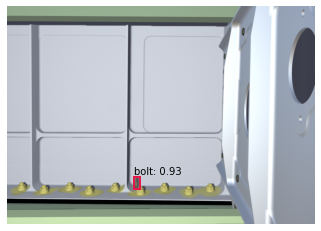

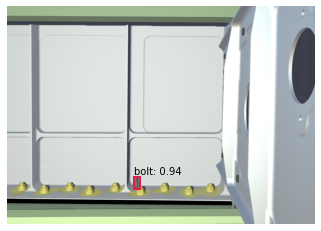

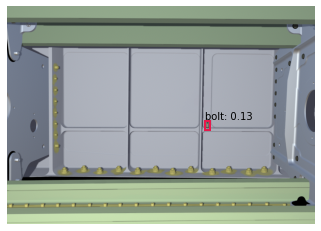

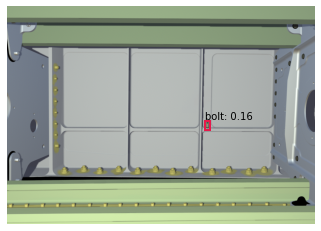

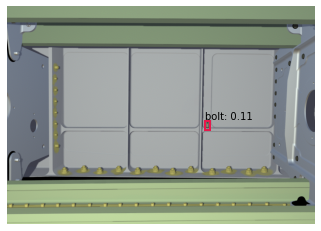

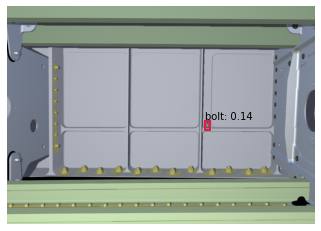

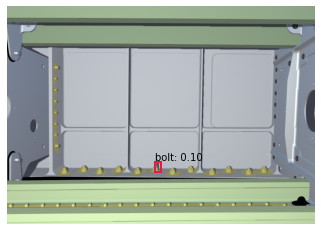

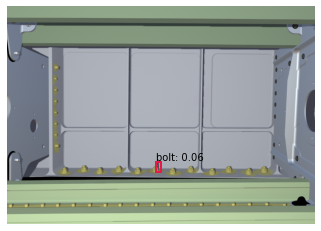

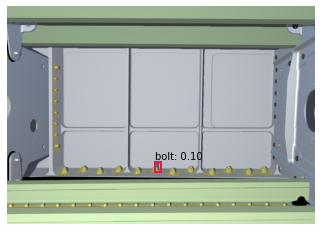

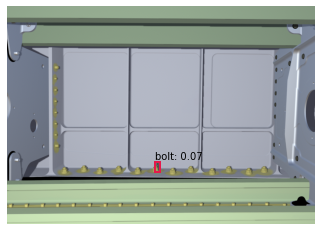

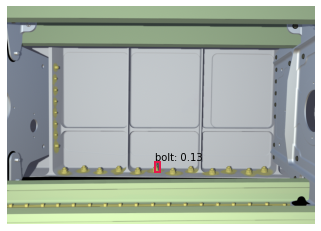

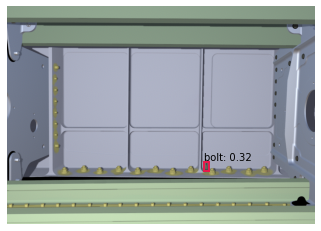

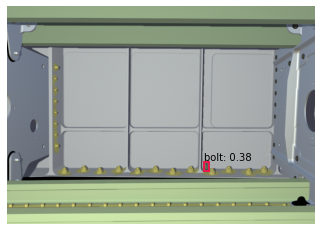

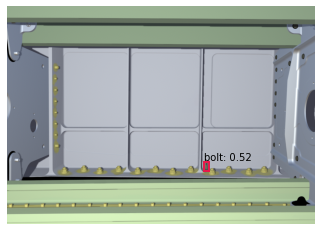

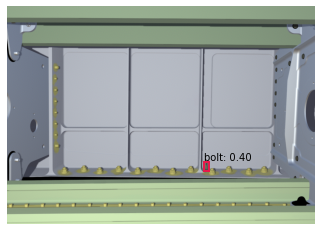

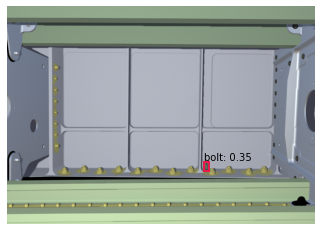

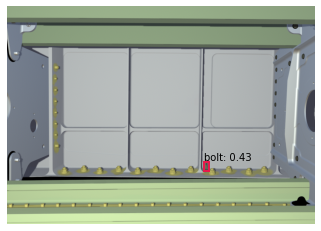

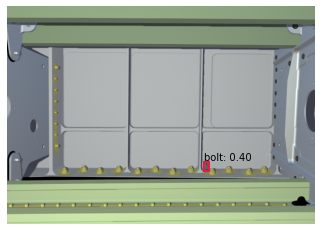

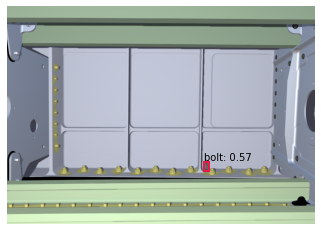

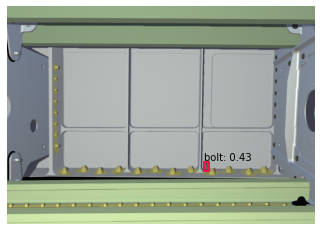

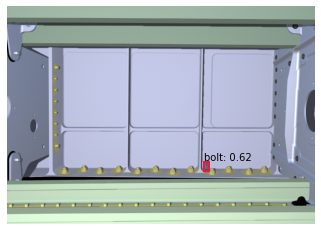

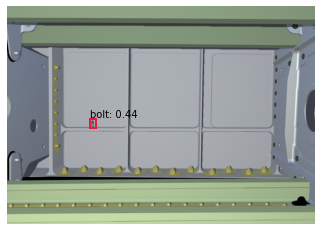

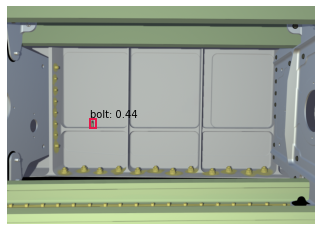

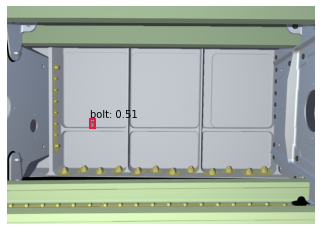

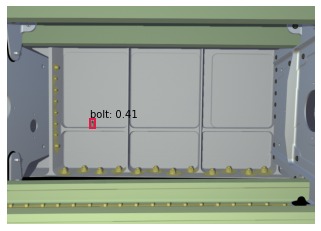

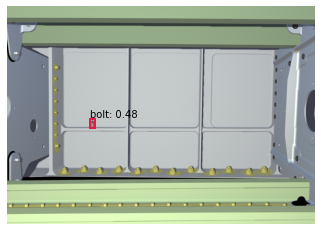

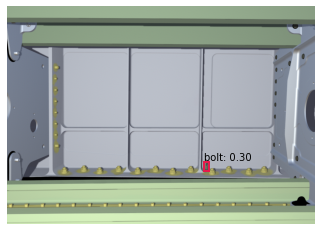

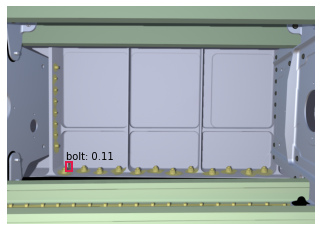

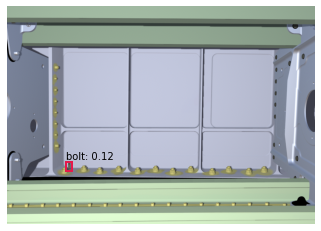

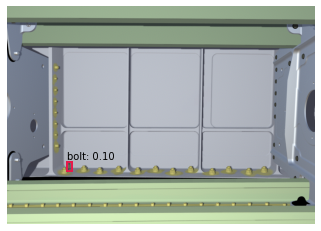

In [81]:
for im in os.listdir(folder)[:-1]:
    img_path = folder + im
    img = Image.open(img_path)
    
    bboxes = get_bbox_pred(model, img)
    fig = plot_bboxes(bboxes, img)
    
    box_path = folder + "bboxes/" + im[:-4] + "_bbox.png"
    print(box_path)
    plt.savefig(box_path)

In [89]:
from zipfile import ZipFile

with ZipFile('bboxes.zip', 'w') as myzip:
    for im in os.listdir("/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/"):
        myzip.write("/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/"+im, im)


In [77]:
os.listdir("/scratch/coco/FTI_BOLTS_SIDEWARD/val2017/bboxes/")

['image_527_Standard_staticforeignobjects_bbox.png',
 'image_528_Standard_staticforeignobjects_bbox.png',
 'image_529_Standard_staticforeignobjects_bbox.png',
 'image_530_Standard_staticforeignobjects_bbox.png',
 'image_531_Standard_staticforeignobjects_bbox.png',
 'image_532_Standard_staticforeignobjects_bbox.png',
 'image_533_Standard_staticforeignobjects_bbox.png',
 'image_534_Standard_staticforeignobjects_bbox.png',
 'image_535_Standard_staticforeignobjects_bbox.png',
 'image_536_Standard_staticforeignobjects_bbox.png',
 'image_949_Standard_staticforeignobjects_bbox.png',
 'image_950_Standard_staticforeignobjects_bbox.png',
 'image_951_Standard_staticforeignobjects_bbox.png',
 'image_952_Standard_staticforeignobjects_bbox.png',
 'image_953_Standard_staticforeignobjects_bbox.png',
 'image_954_Standard_staticforeignobjects_bbox.png',
 'image_955_Standard_staticforeignobjects_bbox.png',
 'image_956_Standard_staticforeignobjects_bbox.png',
 'image_957_Standard_staticforeignobjects_bbox